# Price Prediction
## Module 2


### Table of Contents:
* [Load Dependencies]
* [Data Gathering]
* [Preprocessing]
* [Outliers]
* [Filling missing values]
* [Pre-processing amenities]
* [Model Preparation and Pipelines]

## Load Dependencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import sys
import itertools
import warnings
import string
import math
warnings.filterwarnings("ignore")

#SCIKIT-LEARN
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

#Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

## Data Gathering

In [2]:
#Read listings data from 'London, England, United Kingdom'
data = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2021-12-07/data/listings.csv.gz") #, parse_dates=[11])
airbnb = pd.DataFrame(data)

In [3]:
airbnb.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20211207182339,2021-12-09,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,...,4.90,4.65,4.75,NaN,f,2,1,1,0,0.16
1,15400,https://www.airbnb.com/rooms/15400,20211207182339,2021-12-09,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,4.82,4.93,4.73,NaN,f,1,1,0,0,0.61
2,17402,https://www.airbnb.com/rooms/17402,20211207182339,2021-12-09,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,...,4.66,4.85,4.59,NaN,f,1,1,0,0,0.33
3,17506,https://www.airbnb.com/rooms/17506,20211207182339,2021-12-09,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,https://a0.muscache.com/pictures/11901327/e63d...,67915,https://www.airbnb.com/users/show/67915,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN
4,25123,https://www.airbnb.com/rooms/25123,20211207182339,2021-12-09,Clean big Room in London (Room 1),Big room with double bed/ clean sheets/ clean ...,Barnet is one of the largest boroughs in Londo...,https://a0.muscache.com/pictures/456905/a004b9...,103583,https://www.airbnb.com/users/show/103583,...,4.89,4.45,4.74,NaN,t,3,0,3,0,0.91


In [4]:
airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

## Preprocessing

### Dropping columns

Some columns seem irrelevant for pricing, are incomplete or are duplicates. 

Examples here: **host_name**, **host_url**, **host_location**, are all related to the host personally and not to the appartment or its price.

Neighbourhood or bathrooms seems weird to delete here, but when looking in the dataframe above, you can see there are no values in these columns. 

The **minimum_minimum_nights** etc. are redundant

**[TO EXPAND]**

In [3]:
airbnb = airbnb.drop(columns ='id')
airbnb = airbnb.drop(columns ='listing_url')
airbnb = airbnb.drop(columns ='scrape_id')
airbnb = airbnb.drop(columns ='last_scraped')
airbnb = airbnb.drop(columns ='name')
airbnb = airbnb.drop(columns ='picture_url')
airbnb = airbnb.drop(columns ='host_id')
airbnb = airbnb.drop(columns ='host_url')
airbnb = airbnb.drop(columns ='host_name')
airbnb = airbnb.drop(columns ='host_location')
airbnb = airbnb.drop(columns ='host_about')
airbnb = airbnb.drop(columns ='host_thumbnail_url')
airbnb = airbnb.drop(columns ='host_picture_url')
airbnb = airbnb.drop(columns ='host_neighbourhood')
airbnb = airbnb.drop(columns ='host_listings_count')
airbnb = airbnb.drop(columns ='host_verifications')
airbnb = airbnb.drop(columns ='host_has_profile_pic')
airbnb = airbnb.drop(columns ='neighbourhood')
airbnb = airbnb.drop(columns ='neighbourhood_group_cleansed')
airbnb = airbnb.drop(columns ='bathrooms')
airbnb = airbnb.drop(columns ='minimum_minimum_nights')
airbnb = airbnb.drop(columns ='maximum_minimum_nights')
airbnb = airbnb.drop(columns ='minimum_maximum_nights')
airbnb = airbnb.drop(columns ='maximum_maximum_nights')
airbnb = airbnb.drop(columns ='minimum_nights_avg_ntm')
airbnb = airbnb.drop(columns ='maximum_nights_avg_ntm')
airbnb = airbnb.drop(columns ='calendar_updated')
airbnb = airbnb.drop(columns ='has_availability')
airbnb = airbnb.drop(columns ='calendar_last_scraped')
airbnb = airbnb.drop(columns ='number_of_reviews_ltm') #Check
airbnb = airbnb.drop(columns ='number_of_reviews_l30d') #Check
airbnb = airbnb.drop(columns ='first_review')
airbnb = airbnb.drop(columns ='last_review')
airbnb = airbnb.drop(columns ='license') #Empty
airbnb = airbnb.drop(columns ='calculated_host_listings_count')
airbnb = airbnb.drop(columns ='calculated_host_listings_count_entire_homes')
airbnb = airbnb.drop(columns ='calculated_host_listings_count_private_rooms')
airbnb = airbnb.drop(columns ='calculated_host_listings_count_shared_rooms')
airbnb = airbnb.drop(columns ='neighborhood_overview')
airbnb = airbnb.drop(columns ='description')
#airbnb = airbnb.drop(columns ='host_response_time')
#airbnb = airbnb.drop(columns ='host_response_rate')
#airbnb = airbnb.drop(columns ='host_is_superhost')
#airbnb = airbnb.drop(columns ='host_identity_verified')
#airbnb = airbnb.drop(columns ='instant_bookable')
airbnb = airbnb.drop(columns ='property_type') #Deleted since checked unique values
#airbnb = airbnb.drop(columns ='host_since')
#airbnb = airbnb.drop(columns ='host_acceptance_rate')
#airbnb = airbnb.drop(columns ='host_total_listings_count')

In [4]:
airbnb.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,2009-11-16,within a few hours,100%,85%,f,3.0,t,Islington,51.56861,-0.11270,...,22,4.86,4.80,4.85,4.80,4.90,4.65,4.75,f,0.16
1,2009-12-05,within a day,67%,50%,f,1.0,t,Kensington and Chelsea,51.48780,-0.16813,...,89,4.79,4.84,4.88,4.87,4.82,4.93,4.73,f,0.61
2,2010-01-04,within an hour,80%,70%,f,18.0,t,Westminster,51.52195,-0.14094,...,43,4.69,4.80,4.68,4.66,4.66,4.85,4.59,f,0.33
3,2010-01-05,NaN,NaN,NaN,f,3.0,t,Hammersmith and Fulham,51.47935,-0.19743,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
4,2010-04-05,NaN,NaN,NaN,f,3.0,t,Barnet,51.57438,-0.21081,...,129,4.78,4.70,4.94,4.91,4.89,4.45,4.74,t,0.91


### Data Cleaning

To check for correlation, the columns need to be either integer or float. We check the types and the missing values they have.

Here we are pre-processing the data, to either "clean" it to be able to generate floats, such as removing dollar signs, or we rank the values.

In [5]:
#checking which columns have missing values and how many, to determine what steps to take in preprocessing
print(airbnb.isna().sum())

host_since                        59
host_response_time             34334
host_response_rate             34334
host_acceptance_rate           32993
host_is_superhost                 59
host_total_listings_count         59
host_identity_verified            59
neighbourhood_cleansed             0
latitude                           0
longitude                          0
room_type                          0
accommodates                       0
bathrooms_text                   244
bedrooms                        4017
beds                            3646
amenities                          0
price                              0
minimum_nights                     0
maximum_nights                     0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
number_of_reviews                  0
review_scores_rating           18559
review_scores_accuracy         19877
review_scores_cleanliness      19866
r

In [8]:
airbnb['bathrooms_text'][66600:]

#I think it makes sense to change it to numerical values only, because the "baths" can be either private or shared, 
#and thus no conclusion can be made based on this data whether shared or private influences

66600              1 bath
66601             2 baths
66602      1 private bath
66603              1 bath
66604       1 shared bath
66605              1 bath
66606       1 shared bath
66607           1.5 baths
66608              1 bath
66609              1 bath
66610              1 bath
66611              1 bath
66612              1 bath
66613    2.5 shared baths
66614      1 private bath
66615              1 bath
66616    2.5 shared baths
66617             2 baths
66618           1.5 baths
66619              1 bath
66620              1 bath
66621             2 baths
66622              1 bath
66623              1 bath
66624      1 private bath
66625              1 bath
66626             2 baths
66627       1 shared bath
66628             2 baths
66629              1 bath
66630              1 bath
66631              1 bath
66632              1 bath
66633              1 bath
66634              1 bath
66635              1 bath
66636              1 bath
66637           2.5 baths
66638       

In [6]:
#Code to clean currency of price feature
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)
airbnb['price'] = airbnb['price'].apply(clean_currency).astype('float')

In [7]:
print('Checking the unique values to see how we can change this')
print(airbnb['host_response_time'].unique())
airbnb.loc[airbnb['host_response_time'] == 'within a few hours', 'host_response_time'] = 5
airbnb.loc[airbnb['host_response_time'] == 'within a day', 'host_response_time'] = 4
airbnb.loc[airbnb['host_response_time'] == 'within an hour', 'host_response_time'] = 3
airbnb.loc[airbnb['host_response_time'] == 'a few days or more', 'host_response_time'] = 2
#airbnb['host_response_time'].fillna(0, inplace= True) --> should we fill it here or after correlation matrix
airbnb['host_response_time']

Checking the unique values to see how we can change this
['within a few hours' 'within a day' 'within an hour' nan
 'a few days or more']


0          5
1          4
2          3
3        NaN
4        NaN
        ... 
66636      3
66637      3
66638    NaN
66639      3
66640    NaN
Name: host_response_time, Length: 66641, dtype: object

In [8]:
#this function removes the percentage signs
def clean_rate(x):
    if isinstance(x, str):
        return(x.replace('%', ''))
    return(x)

In [9]:
airbnb['host_response_rate'] = airbnb['host_response_rate'].apply(clean_rate).astype('float')
airbnb['host_acceptance_rate'] = airbnb['host_acceptance_rate'].apply(clean_rate).astype('float')

#here I change response and acceptance rate to float, only wondering whether it would make sense to divide by 100 as its a percentage

In [10]:
#superhost to 0 and 1 (0=false, 1 = true)

airbnb.loc[airbnb['host_is_superhost'] == 't', 'host_is_superhost'] = 1
airbnb.loc[airbnb['host_is_superhost'] == 'f', 'host_is_superhost'] = 0
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].astype(float)

#same for host_identity verified

airbnb.loc[airbnb['host_identity_verified'] == 't', 'host_identity_verified'] = 1
airbnb.loc[airbnb['host_identity_verified'] == 'f', 'host_identity_verified'] = 0
airbnb['host_identity_verified'] = airbnb['host_identity_verified'].astype(float)
#same for instant_bookable

airbnb.loc[airbnb['instant_bookable'] == 't', 'instant_bookable'] = 1
airbnb.loc[airbnb['instant_bookable'] == 'f', 'instant_bookable'] = 0
airbnb['instant_bookable'] = airbnb['instant_bookable'].astype(float)


In [11]:
airbnb.loc[airbnb['room_type'] == 'Entire home/apt', 'room_type'] = 4
airbnb.loc[airbnb['room_type'] == 'Hotel room', 'room_type'] = 3
airbnb.loc[airbnb['room_type'] == 'Private room', 'room_type'] = 2
airbnb.loc[airbnb['room_type'] == 'Shared room', 'room_type'] = 1
airbnb['room_type'] = airbnb['room_type'].astype(float)
#not sure if this makes sense regarding the numbers hotel room and private room, looking at luxury perspective and probably costs, i did it like this

In [12]:
#changing bathroom to float by removing text
airbnb['bathrooms_text'] = airbnb['bathrooms_text'].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)

In [13]:
#double check for the class
airbnb['bathrooms_text'].apply(type).value_counts()

<class 'float'>    66641
Name: bathrooms_text, dtype: int64

In [14]:
#changing host_since to years instead of dates to be able to use it

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

In [15]:
#apply function

airbnb['host_since_year'] = airbnb.apply(lambda row: get_host_since_year(row),axis=1)
#airbnb['host_since_year'] = airbnb['host_since'].apply(get_host_since_year)

In [16]:
#changing the longest year to the highest rank, shortest to lowest rank
airbnb.loc[airbnb['host_since_year'] == '2008.', 'host_since_year'] = 14
airbnb.loc[airbnb['host_since_year'] == '2009.', 'host_since_year'] = 13
airbnb.loc[airbnb['host_since_year'] == '2010.', 'host_since_year'] = 12
airbnb.loc[airbnb['host_since_year'] == '2011.', 'host_since_year'] = 11
airbnb.loc[airbnb['host_since_year'] == '2012.', 'host_since_year'] = 10
airbnb.loc[airbnb['host_since_year'] == '2013.', 'host_since_year'] = 9
airbnb.loc[airbnb['host_since_year'] == '2014.', 'host_since_year'] = 8
airbnb.loc[airbnb['host_since_year'] == '2015.', 'host_since_year'] = 7
airbnb.loc[airbnb['host_since_year'] == '2016.', 'host_since_year'] = 6
airbnb.loc[airbnb['host_since_year'] == '2017.', 'host_since_year'] = 5
airbnb.loc[airbnb['host_since_year'] == '2018.', 'host_since_year'] = 4
airbnb.loc[airbnb['host_since_year'] == '2019.', 'host_since_year'] = 3
airbnb.loc[airbnb['host_since_year'] == '2020.', 'host_since_year'] = 2
airbnb.loc[airbnb['host_since_year'] == '2021.', 'host_since_year'] = 1

airbnb['host_since_year'] = airbnb['host_since_year'].astype(float)

<AxesSubplot:xlabel='price', ylabel='Density'>

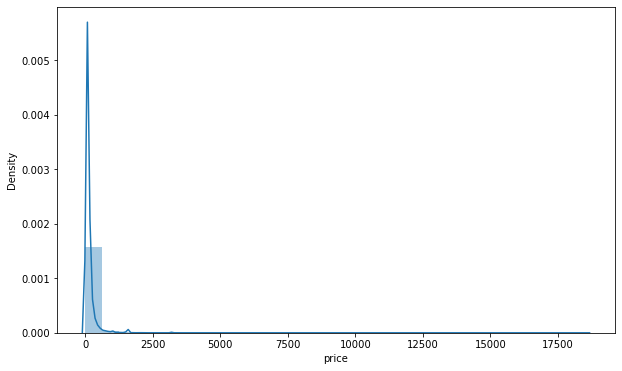

In [17]:
plt.figure(figsize=(10, 6))
sns.distplot(airbnb['price'],bins=30)

### Neighbourhood Analysis and Visualization

In [18]:
un = "There are {} unique neighbourhoods"
print(un.format(len(airbnb['neighbourhood_cleansed'].unique())))
print('******************************')
print('Counts:') 
print(airbnb['neighbourhood_cleansed'].value_counts())

There are 33 unique neighbourhoods
******************************
Counts:
Westminster               7022
Tower Hamlets             5538
Hackney                   5117
Camden                    4527
Kensington and Chelsea    4508
Southwark                 3929
Islington                 3879
Lambeth                   3727
Wandsworth                3442
Hammersmith and Fulham    2953
Lewisham                  1910
Brent                     1868
Haringey                  1856
Newham                    1604
Ealing                    1536
Barnet                    1523
Greenwich                 1434
Waltham Forest            1248
Merton                    1099
Croydon                   1055
Richmond upon Thames      1027
Hounslow                   988
Redbridge                  617
Hillingdon                 586
Enfield                    560
Bromley                    546
Kingston upon Thames       486
Harrow                     423
Barking and Dagenham       410
City of London             

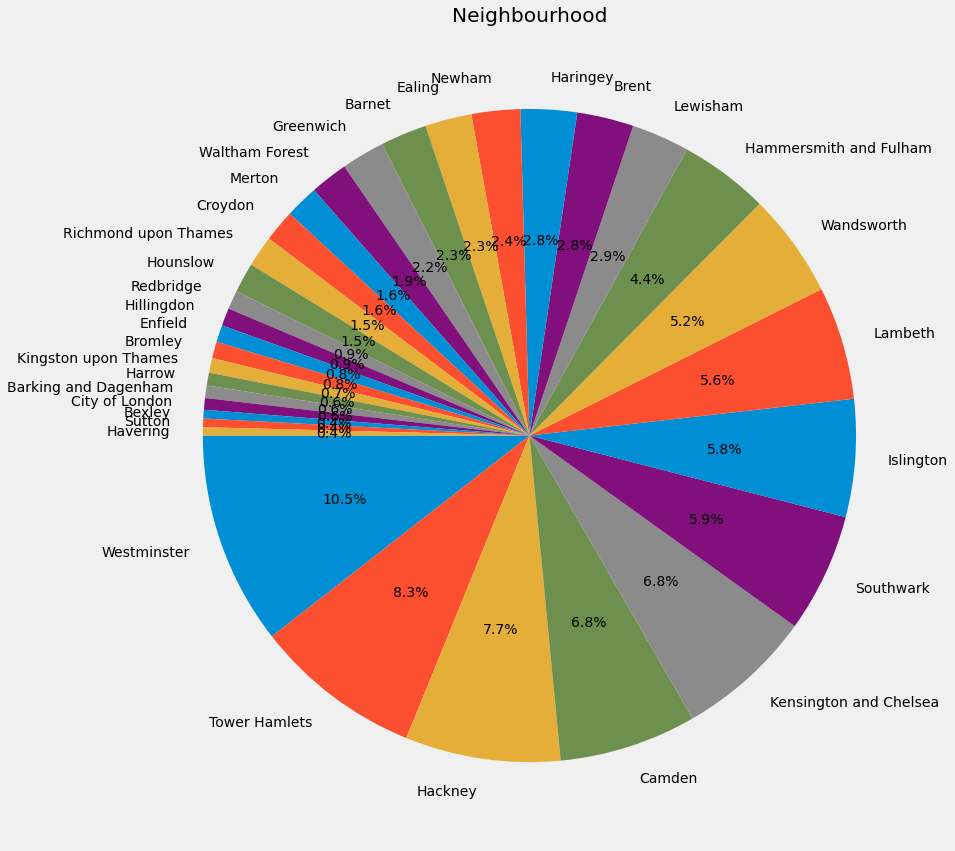

In [19]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,14))
plt.title("Neighbourhood")
g = plt.pie(airbnb.neighbourhood_cleansed.value_counts(), labels=airbnb.neighbourhood_cleansed.value_counts().index,autopct='%1.1f%%', startangle=180)
plt.show()

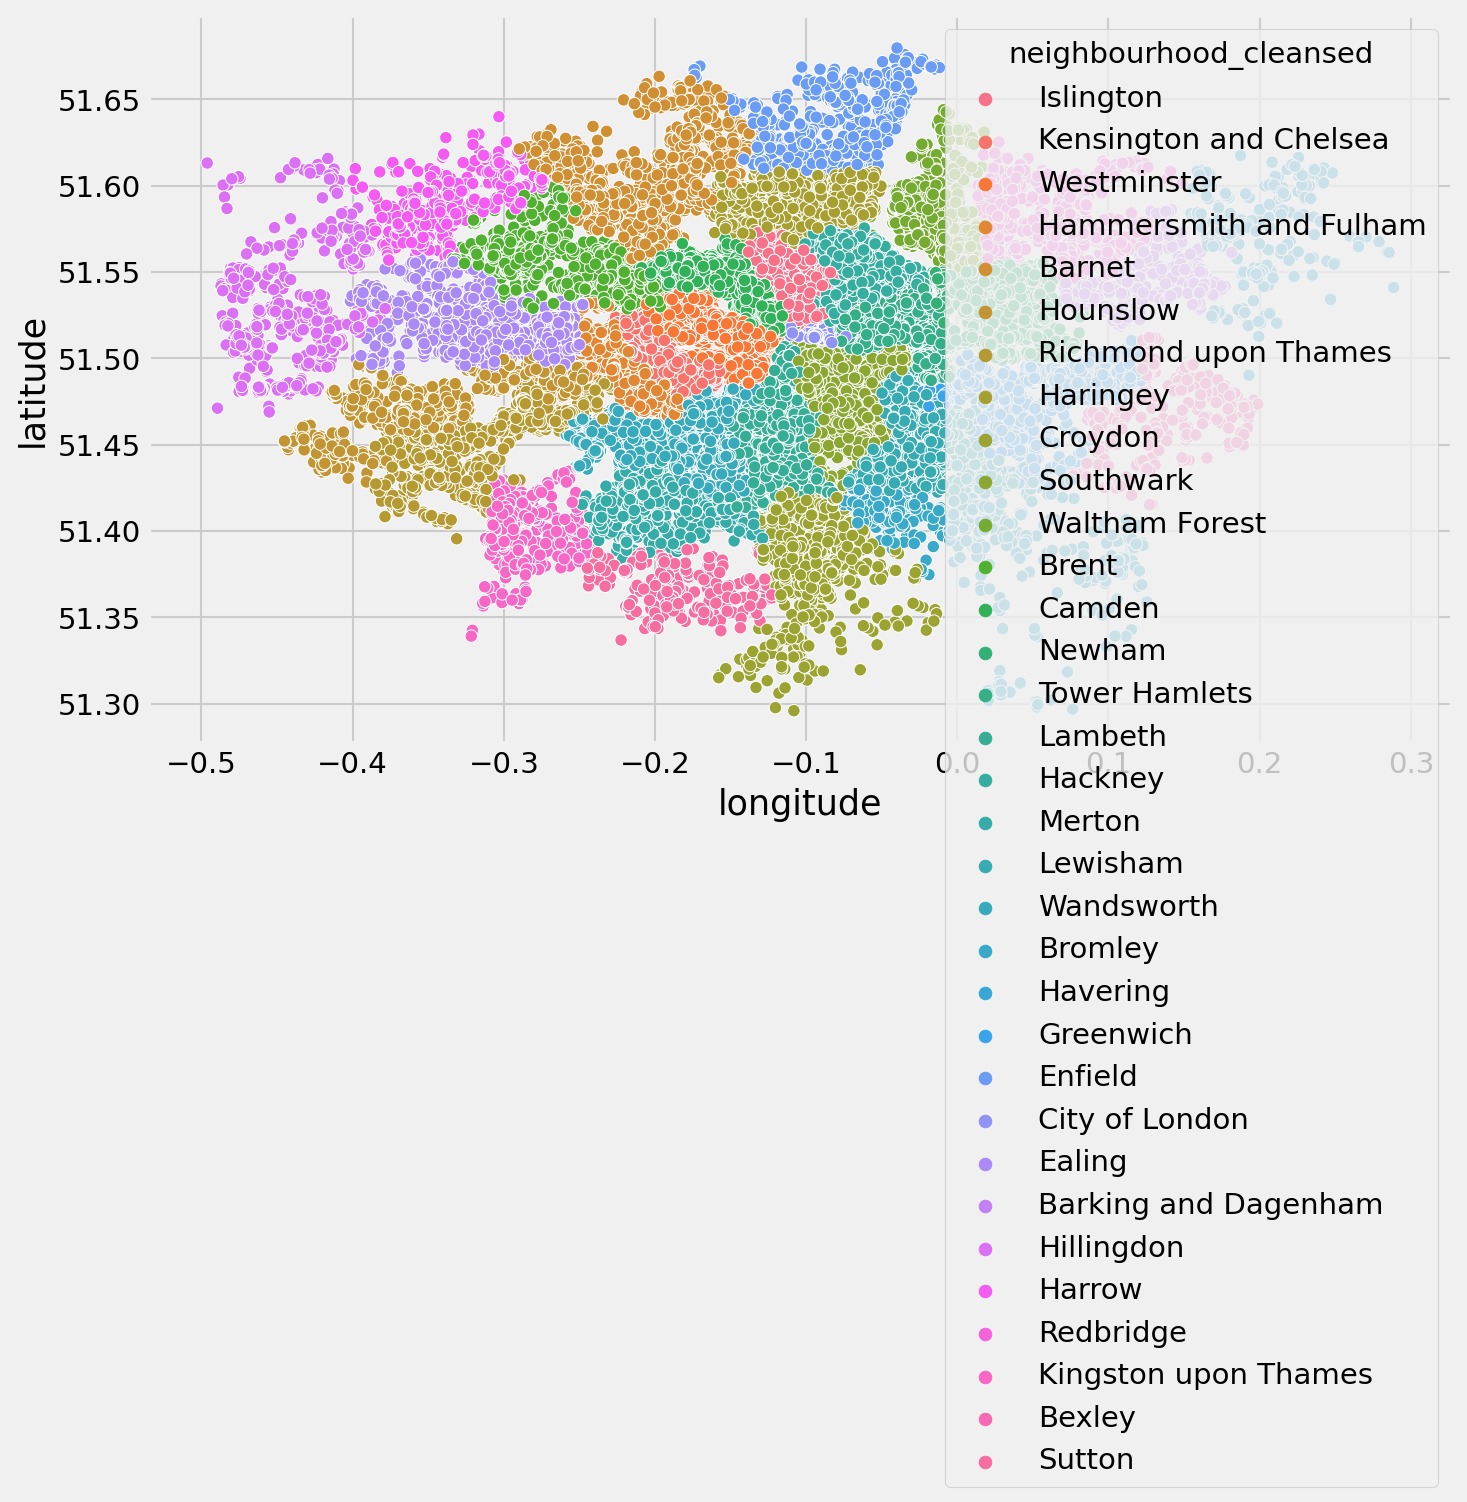

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6), dpi = 150)
sns.scatterplot(airbnb.longitude,airbnb.latitude,hue=airbnb.neighbourhood_cleansed)
plt.ioff()

In [21]:
airbnb['mean_price_neighbourhood'] = airbnb.groupby('neighbourhood_cleansed')['price'].transform('mean')

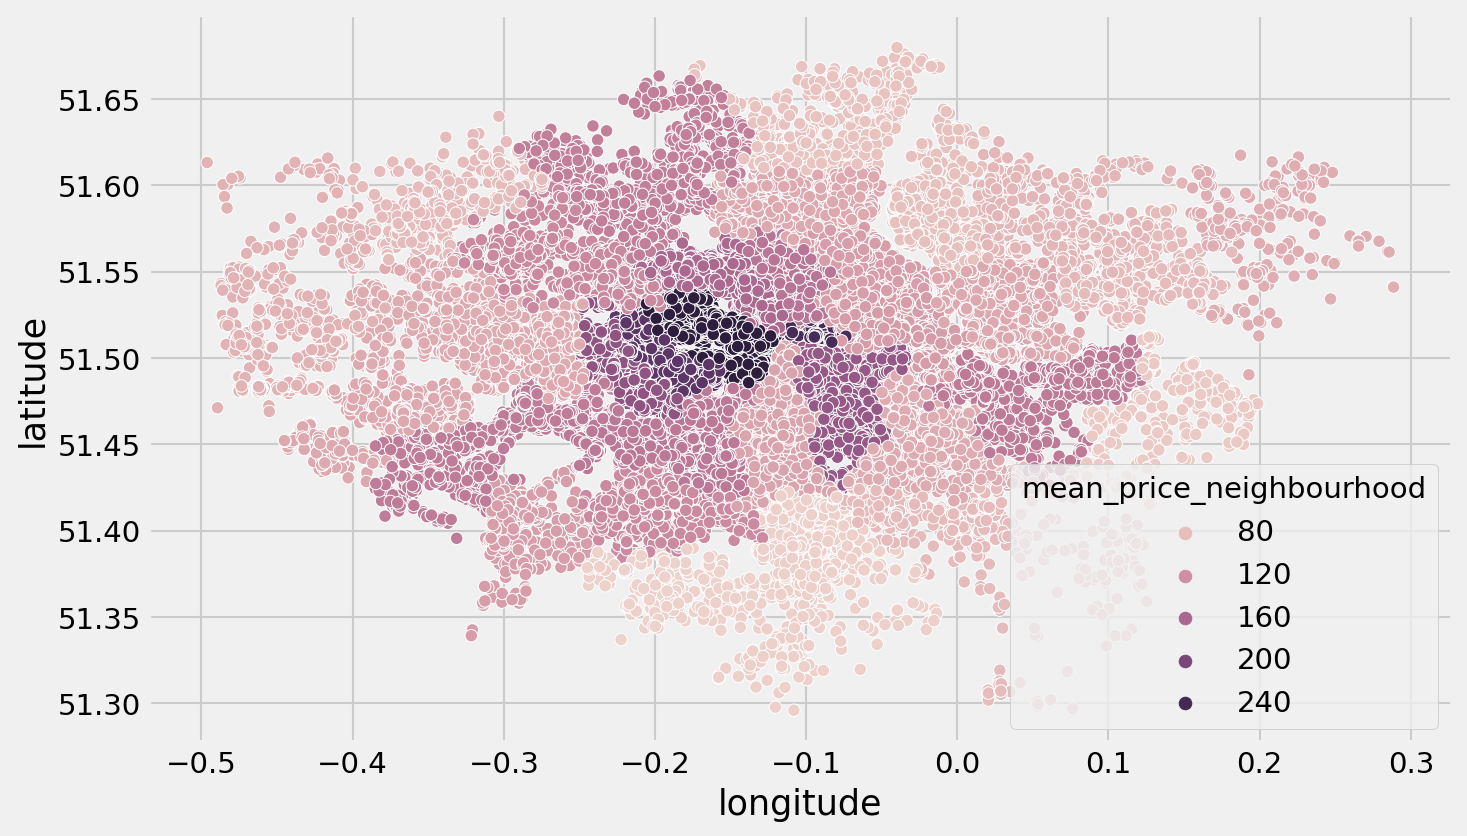

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6), dpi = 150)
sns.scatterplot(airbnb.longitude,airbnb.latitude,hue=airbnb.mean_price_neighbourhood)
plt.ioff()

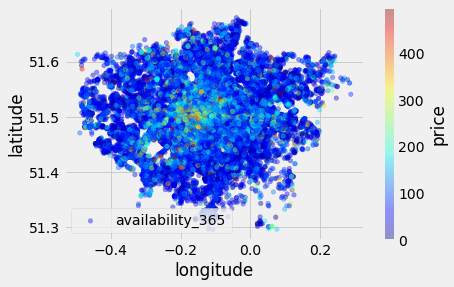

In [23]:
ax=airbnb[airbnb.price<500].plot(kind='scatter', x='longitude',y='latitude',label='availability_365',c='price',cmap=plt.get_cmap('jet'),colorbar=True,alpha=0.4)
ax.legend()
plt.ioff()
plt.show()

In [24]:
conditions = [
    (airbnb['mean_price_neighbourhood'] >= 175),
    (airbnb['mean_price_neighbourhood'] <175) & (airbnb['mean_price_neighbourhood'] >= 150),
    (airbnb['mean_price_neighbourhood'] < 150) & (airbnb['mean_price_neighbourhood'] >=125),
    (airbnb['mean_price_neighbourhood'] <125) & (airbnb['mean_price_neighbourhood']>=100),
    (airbnb['mean_price_neighbourhood'] <100) & (airbnb['mean_price_neighbourhood']>=75),
    (airbnb['mean_price_neighbourhood'] <75) & (airbnb['mean_price_neighbourhood']>=0)]

values = [6,5,4,3,2,1]

airbnb['final_neighbourhood'] = np.select(conditions, values)

print(airbnb['final_neighbourhood'])

0        4
1        6
2        6
3        6
4        4
        ..
66636    1
66637    2
66638    2
66639    6
66640    6
Name: final_neighbourhood, Length: 66641, dtype: int64


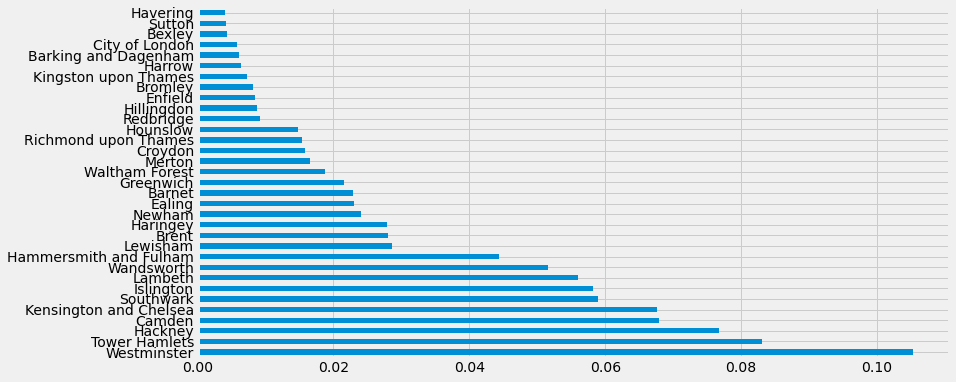

In [25]:
plt.figure(figsize = (12, 6))
airbnb['neighbourhood_cleansed'].value_counts(normalize=True).plot.barh()
plt.show()

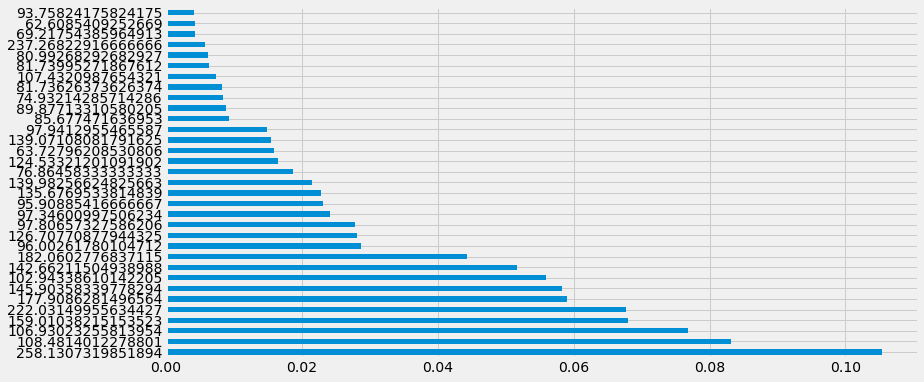

In [26]:
plt.figure(figsize = (12, 6))
airbnb['mean_price_neighbourhood'].value_counts(normalize=True).plot.barh()
plt.show()

In [27]:
airbnb.drop(columns = ['mean_price_neighbourhood', 'neighbourhood_cleansed', 'host_since'], inplace=True)

### Correlation

We decided to use Pearson Correlation which is the traditional most used Corr measure. It's a parametric correlation that measures a linear dependence between two variables (x and y) and depends on the distribution of the data.

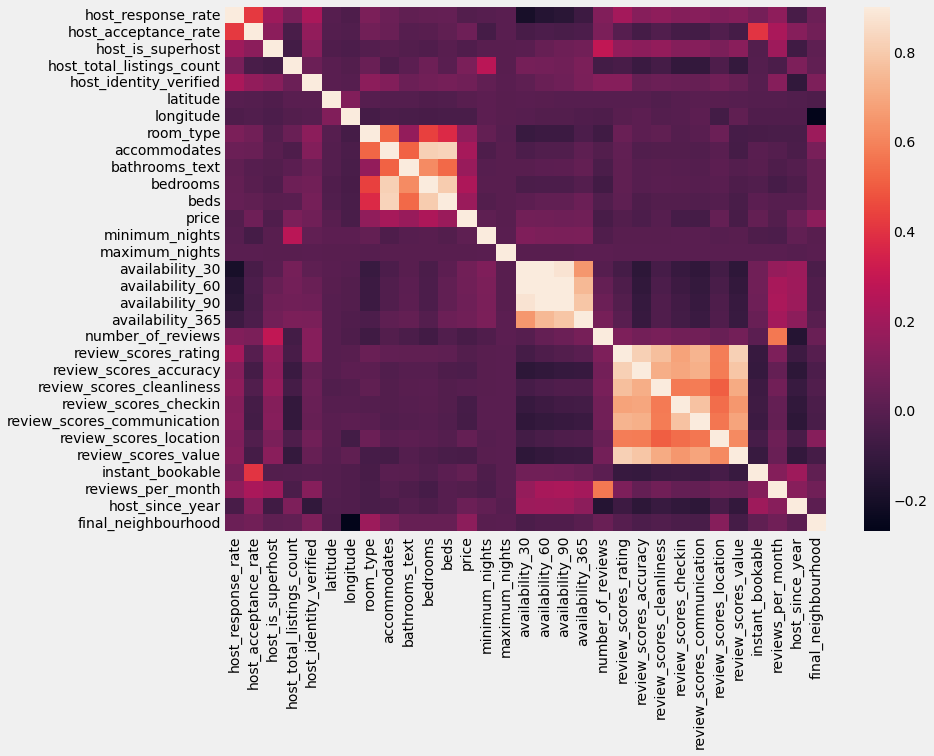

In [28]:
corr_matrix = airbnb.corr()
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9); 

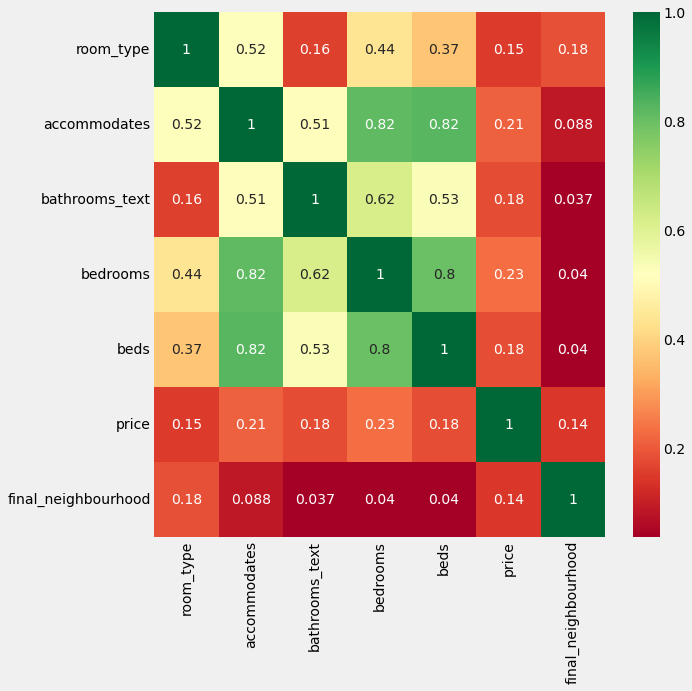

In [29]:
corrmat = airbnb.corr()
top_corr_features = corrmat.index[abs(corrmat["price"])>0.1]
plt.figure(figsize=(9,9))
g = sns.heatmap(airbnb[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
var = airbnb[airbnb.columns[1:]].corr()['price'][:]
var

#as you can see, no high correlaions. Highest is .23
#Correlations between beds and bedrooms obviously make sense, but they could impact price differently and thus they are not removed

host_response_rate            -0.016051
host_acceptance_rate           0.059130
host_is_superhost             -0.025941
host_total_listings_count      0.091443
host_identity_verified         0.063989
latitude                      -0.003223
longitude                     -0.041708
room_type                      0.152289
accommodates                   0.212620
bathrooms_text                 0.176816
bedrooms                       0.232088
beds                           0.181067
price                          1.000000
minimum_nights                 0.014884
maximum_nights                -0.001203
availability_30                0.070456
availability_60                0.067247
availability_90                0.062569
availability_365               0.065047
number_of_reviews             -0.049236
review_scores_rating          -0.016055
review_scores_accuracy        -0.033463
review_scores_cleanliness     -0.007706
review_scores_checkin         -0.054171
review_scores_communication   -0.056457


#### Kendall Tau’s Rank Correlation

While Pearson’s measures a linear relationship between two variables,  Kendall’s measures the monotonic relationship: how likely it is for two variables to move in the same direction, but not necessarily at a constant rate. 

We decided to try if it fits for our use case.

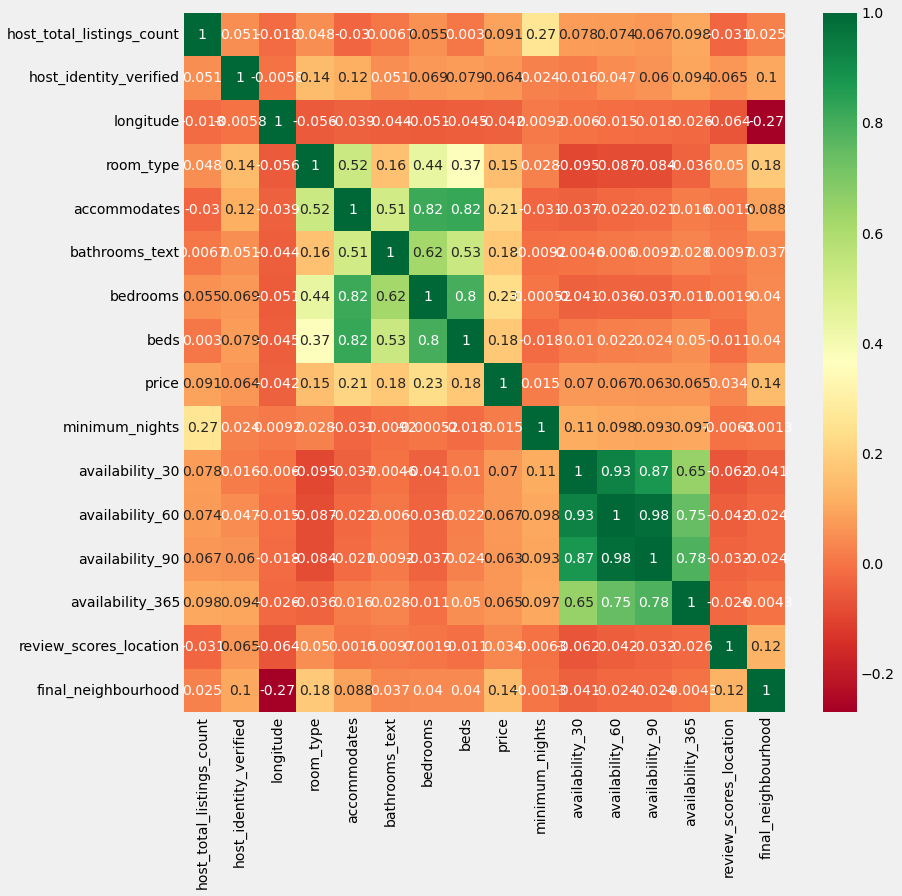

In [31]:
corrmat = airbnb.corr(method='kendall')
top_corr_features = corrmat.index[abs(corrmat["price"])>0.1]
plt.figure(figsize=(12,12))
g = sns.heatmap(airbnb[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Outliers detection and analysis

As can be seen in the graph above, the graph is very skewed. This is because of outliers and therefore we will remove every value that is more than 3 std from the mean. This is a general way of removing outliers. 

In [32]:
#checking the distribution of price in order to remove outliers
mean_price = airbnb['price'].mean()
std_price = airbnb['price'].std()
min_z = mean_price - 3 * std_price
max_z = mean_price + 3 * std_price

print(mean_price)
print(std_price)
print(min_z)
print(max_z)

145.20722978346663
349.93237346485677
-904.5898906111038
1195.004350178037


#### IQR (Interquantile Range)

IQR is based on the concept that there are minimum and maximum points defined as Q1–1.5*IQR and Q3+1.5*IQR respectively. Any point outside this range is an outlier.
It's one of the most widely adopted method and so we'll start using that

In [33]:
def remove_outlier_IQR(df, column):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df[column]<(Q1-1.5*IQR)) | (df[column]>(Q3+1.5*IQR)))]
    return df_final

#### Hampel's Filter

Use the median to filter data and spot outliers

In [37]:
def remove_outlier_Hampel(df, column):
    med=df[column].median()
    List=abs(df[column]-med)
    cond=List.median()*4.5
    good_list=List[~(List>cond)]
    return good_list

#### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN groups together points that are close to each other based on a distance measurement (the most adopted is the Euclidean distance) and a minimum number of points. This makes it suitable for outliers detection in low-density regions.

In [38]:
def remove_outliers_DBSCAN(df,eps, column):
    outlier_detection = DBSCAN(eps = eps, min_samples = 5)
    clusters = outlier_detection.fit_predict(df[column].values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = clusters
    return data['cluster']

After some considerations the IQR is the one that performs better, so we'll go for it

In [39]:
#Safety Check code
df_outlier_removed=remove_outlier_IQR(airbnb, 'price')
df_outlier_removed=pd.DataFrame(df_outlier_removed)
df_outlier_removed

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,room_type,accommodates,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,host_since_year,final_neighbourhood
0,5,100.0,85.0,0.0,3.0,1.0,51.568610,-0.112700,2.0,2,...,4.80,4.85,4.80,4.90,4.65,4.75,0.0,0.16,2009.0,4
1,4,67.0,50.0,0.0,1.0,1.0,51.487800,-0.168130,4.0,2,...,4.84,4.88,4.87,4.82,4.93,4.73,0.0,0.61,2009.0,6
2,3,80.0,70.0,0.0,18.0,1.0,51.521950,-0.140940,4.0,6,...,4.80,4.68,4.66,4.66,4.85,4.59,0.0,0.33,2010.0,6
3,NaN,NaN,NaN,0.0,3.0,1.0,51.479350,-0.197430,2.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2010.0,6
4,NaN,NaN,NaN,0.0,3.0,1.0,51.574380,-0.210810,2.0,2,...,4.70,4.94,4.91,4.89,4.45,4.74,1.0,0.91,2010.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66635,3,100.0,98.0,1.0,0.0,1.0,51.569267,-0.267770,4.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2019.0,4
66636,3,100.0,100.0,1.0,13.0,1.0,51.419345,-0.079681,4.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2016.0,1
66637,3,100.0,98.0,0.0,9.0,1.0,51.502002,-0.276895,4.0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2017.0,2
66638,NaN,NaN,NaN,1.0,5.0,1.0,51.599308,-0.114763,4.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2019.0,2


In [34]:
airbnb=remove_outlier_IQR(airbnb, 'price')

In [41]:
#airbnb.drop(airbnb[airbnb['price'] >= 1195].index, inplace = True)

## Filling missing values

Everything review related, a missing value probably means there is no review and therefore these can be changed to 0's. Same for host_acceptance_rate, response time and rate. It probably means they did not have a booking or a message yet to respond to. Therefore, we change them all to 0.

Regarding beds, we have seen there is a strong correlation between beds, bedrooms and accomodates. Therefore, we are going to fill the missing values of beds and bedrooms based on accomodates. 

We calculated what the average amount of beds and bedrooms is per accomodate, and then we multiple this by the amount of accomodates to see what it the missing value would be on average. As here we take into account the number of accomodates, it is more accurate than filling out just a median, mean or most frequent value. As it is an important predictor probably and there were a lot of missing values, we could not just drop them.

We did drop bathrooms_text, as there were fewer missing values and a lower correlation between bathrooms_text and accomodates and therefore we thought it would be more accurate for our model to remove the ±500 missing values (less than 1% of the data).

Also, the missing values regarding host were 59 and so little that we dropped them. It is also difficult interpeting where these values come from.


In [35]:
#I think: put host_response_rate,time and acceptance rate to 0, remove the 59 missing values regarding hosts, everything regarding reviews to 0 
airbnb['review_scores_rating'].fillna(airbnb['review_scores_rating'].median(), inplace=True)
airbnb['review_scores_checkin'].fillna(airbnb['review_scores_checkin'].median(), inplace=True)
airbnb['review_scores_accuracy'].fillna(airbnb['review_scores_accuracy'].median(), inplace=True)
airbnb['review_scores_cleanliness'].fillna(airbnb['review_scores_cleanliness'].median(), inplace=True)
airbnb['review_scores_communication'].fillna(airbnb['review_scores_communication'].median(), inplace=True)
airbnb['review_scores_location'].fillna(airbnb['review_scores_location'].median(), inplace=True)
airbnb['review_scores_value'].fillna(airbnb['review_scores_value'].median(), inplace=True)
airbnb['reviews_per_month'].fillna(airbnb['reviews_per_month'].median(), inplace=True)

In [36]:
#here we are creating ratios, to create average numbers of beds and bedrooms per accommodate. As there is a very high correlation, this should be accurate

airbnb['ratio_beds'] = airbnb['beds']/airbnb['accommodates']
airbnb['ratio_bedrooms'] = airbnb['bedrooms']/airbnb['accommodates']

#here we take the average of all for beds
sum_beds = airbnb['ratio_beds'].sum()
length = len(airbnb)
avg_beds_A = sum_beds / length

#here we take the average of all for bedrooms
sum_bedrooms = airbnb['ratio_bedrooms'].sum()
avg_bedrooms_A = sum_bedrooms / length

#here we create a new column based on the average for beds
airbnb['avg_beds'] = airbnb['accommodates'] * avg_beds_A

#here we create a new column based on the average for bedrooms
airbnb['avg_bedrooms'] = airbnb['accommodates'] * avg_bedrooms_A

#Now we need a code, that in case a value is NA, it takes from these columns
airbnb["beds"].fillna(airbnb['avg_beds'], inplace = True)
airbnb["bedrooms"].fillna(airbnb['avg_bedrooms'], inplace = True)


In [37]:
airbnb.isna().sum()

# We think the 59 missing values regarding hosts, are not real hosts? Not sure how that works, but only explanation I have

host_response_time             32775
host_response_rate             32775
host_acceptance_rate           31409
host_is_superhost                 57
host_total_listings_count         57
host_identity_verified            57
latitude                           0
longitude                          0
room_type                          0
accommodates                       0
bathrooms_text                   514
bedrooms                           0
beds                               0
amenities                          0
price                              0
minimum_nights                     0
maximum_nights                     0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
number_of_reviews                  0
review_scores_rating               0
review_scores_accuracy             0
review_scores_cleanliness          0
review_scores_checkin              0
review_scores_communication        0
r

In [38]:
airbnb = airbnb[airbnb['bathrooms_text'].notna()]
#deleting the 59 missing values regarding host
#also the bathroom, as its <1% from the data
airbnb['host_since_year'] = airbnb['host_since_year'].dropna()
airbnb['host_identity_verified'] = airbnb['host_identity_verified'].dropna()
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].dropna()
airbnb['host_total_listings_count'] = airbnb['host_total_listings_count'].dropna()


airbnb.dtypes
#here you can see we only need to change amenities and neighbourhood_cleansed to an numerical value

host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
host_is_superhost              float64
host_total_listings_count      float64
host_identity_verified         float64
latitude                       float64
longitude                      float64
room_type                      float64
accommodates                     int64
bathrooms_text                 float64
bedrooms                       float64
beds                           float64
amenities                       object
price                          float64
minimum_nights                   int64
maximum_nights                   int64
availability_30                  int64
availability_60                  int64
availability_90                  int64
availability_365                 int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

## Pre-processing amenities

Amenities was a list of amenities within a column. This list needed be separated, split into new colums (more than 2800 different amenities). We then filtered that all amenities we would keep, needed to have more than 13000 appartments who mentioned these amenities. Otherwise it would only produce noise in the model.

13000 means that 20% of the data has these amenties. This might seem like a very high number, but reducing it to 10% (=6500 treshold) would mean 20 extra amenities are added. In general, so many variables create noise and will be deleted anyhow later on.

In [142]:
airbnb['amenities_list']= airbnb['amenities'].apply(lambda x: x.replace("[","").replace("]","").replace('"',"").split(','))
airbnb['amenities_list']

KeyError: 'amenities'

In [40]:
amenities = airbnb['amenities_list'].apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()
amenities = amenities.apply(lambda x: x.strip().upper()).drop_duplicates()
amenities.to_list()

['HOT WATER',
 'HEATING',
 'COFFEE MAKER',
 'BUILDING STAFF',
 'TV WITH STANDARD CABLE',
 'PACK \\U2019N PLAY/TRAVEL CRIB',
 'CHILDREN\\U2019S BOOKS AND TOYS',
 'FIRE EXTINGUISHER',
 'IRON',
 'FREE PARKING ON PREMISES',
 'LOCK ON BEDROOM DOOR',
 'LUGGAGE DROPOFF ALLOWED',
 'DRYER',
 'HAIR DRYER',
 'ROOM-DARKENING SHADES',
 'STOVE',
 'OVEN',
 'BABYSITTER RECOMMENDATIONS',
 'WIFI',
 'COOKING BASICS',
 'LONG TERM STAYS ALLOWED',
 'KITCHEN',
 'PAID PARKING OFF PREMISES',
 'CARBON MONOXIDE ALARM',
 'PATIO OR BALCONY',
 'CABLE TV',
 'ESSENTIALS',
 'ETHERNET CONNECTION',
 'SMOKE ALARM',
 'FREE STREET PARKING',
 'BATHTUB',
 'EXTRA PILLOWS AND BLANKETS',
 'HANGERS',
 'BED LINENS',
 'SHAMPOO',
 'WASHER',
 'CHILDREN\\U2019S DINNERWARE',
 'OUTLET COVERS',
 'REFRIGERATOR',
 'DISHES AND SILVERWARE',
 'DEDICATED WORKSPACE',
 'CRIB',
 'AIR CONDITIONING',
 'MICROWAVE',
 'ELEVATOR',
 'TV',
 'DISHWASHER',
 'BREAKFAST',
 'SHOWER GEL',
 'PRIVATE ENTRANCE',
 'LOCKBOX',
 'BACKYARD',
 'HIGH CHAIR',
 'FIRST AI

In [41]:
#creating new empty df
am = pd.DataFrame()

for a in [item for item in amenities]:
    am[a] = airbnb['amenities'].apply(lambda x: int(a in x.upper()))
    
airbnb.drop(columns = ['amenities','amenities_list'], inplace = True)

#removing all columns where not more than 13000 houses have the amenity. This means 20% of the data. This reduces noise in the model and creates generalizability
am = am[am.columns[am.sum()>13000]]

#merging df's
airbnb = pd.concat([airbnb, am], axis=1)

In [42]:
airbnb.drop(columns = ['avg_beds', 
                       'avg_bedrooms', 
                       'ratio_bedrooms', 
                       'ratio_beds',
                      'latitude',
                      'longitude',
                      ''], inplace = True)

In [43]:
airbnb.dropna(inplace=True)
X = airbnb.drop(columns = 'price')
y = airbnb['price']

## Model Prep and Pipelines

In [44]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[5, 100.0, 85.0, ..., 0, 0, 0],
       [4, 67.0, 50.0, ..., 0, 0, 0],
       [3, 80.0, 70.0, ..., 1, 0, 0],
       ...,
       [3, 100.0, 98.0, ..., 1, 1, 1],
       [3, 100.0, 100.0, ..., 0, 1, 1],
       [3, 100.0, 98.0, ..., 0, 1, 1]], dtype=object)

In [45]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)
# Defining categorical and numerical features for data preprocessing

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train)

(21256, 57)
(21256,)
(2657, 57)
(2657,)
(2657, 57)
(2657,)


array([[ 1.66197007e+00,  4.35682319e-01,  1.36884622e-03, ...,
         1.50570184e+00, -6.48953468e-01, -7.65372645e-01],
       [-6.14977132e-01, -3.43077300e-01,  7.68814365e-01, ...,
        -6.64142113e-01, -6.48953468e-01, -7.65372645e-01],
       [-6.14977132e-01,  4.35682319e-01,  5.68611186e-01, ...,
        -6.64142113e-01,  1.54094253e+00, -7.65372645e-01],
       ...,
       [-6.14977132e-01,  4.35682319e-01,  3.01673614e-01, ...,
         1.50570184e+00, -6.48953468e-01,  1.30655310e+00],
       [-6.14977132e-01,  4.35682319e-01,  6.68712776e-01, ...,
         1.50570184e+00, -6.48953468e-01, -7.65372645e-01],
       [-6.14977132e-01,  2.40992414e-01,  7.02079972e-01, ...,
        -6.64142113e-01, -6.48953468e-01,  1.30655310e+00]])

In [53]:
print(len(X_train.columns))

58


#### Linear Regression

In [54]:
linear = LinearRegression()
linear.fit(X_train,y_train)
linear.score(X_test,y_test)

base_linear = linear.score(X_test,y_test)

In [55]:
def cv_score (model, X,y,folds):
    scores = cross_val_score(model, X, y, cv=folds)
    return np.mean(scores) 

In [56]:
cv_score(linear,X,y,5)

-39753.001749132425

In [57]:
linear.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [58]:
#from matplotlib import pyplot as plt
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#cm = confusion_matrix(y_test, lr.predict(X_test), labels=lr.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
#disp.plot(cmap="Blues")
#plt.grid(False)
#plt.show()

#### Decision Tree

In [59]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test,y_test)

base_DT = dt.score(X_test,y_test)

In [ ]:
#GRIDSEACRH decision tree



CV_GS_params = {'dt__criterion':['gini', 'entropy'], 
                'dt__max_features':['auto', 'sqrt', 'log2', None],
                'dt__max_depth':[5,6,7],
                'dt__min_samples_split':[2,5,10],
                'dt__min_samples_leaf':[2,3,5],
                'dt__max_leaf_nodes':[10,15,20,25],
                'dt__min_impurity_decrease':[0.0, 0.001, 0.01],
                'dt__ccp_alpha':[0.0, 0.001, 0.01]}

CV_GS = GridSearchCV(dt, CV_GS_params, verbose = 3, cv = 5)
CV_GS.fit(X_train,y_train)
CV_GS.best_params_

#### Random forest

First training a simple model, then gridsearch and finally using these to run another model.

In [60]:
X_train

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,room_type,accommodates,bathrooms_text,bedrooms,...,WASHER,REFRIGERATOR,DISHES AND SILVERWARE,DEDICATED WORKSPACE,MICROWAVE,TV,DISHWASHER,PRIVATE ENTRANCE,FIRST AID KIT,
7618,3,100.0,90.0,1.0,7.0,1.0,4.0,4,1.0,1.000000,...,1,1,1,1,1,1,1,1,1,1
4417,4,100.0,0.0,1.0,1.0,1.0,4.0,2,1.0,1.000000,...,1,1,1,1,1,1,1,0,0,1
47699,2,0.0,0.0,0.0,0.0,0.0,4.0,4,1.0,2.000000,...,1,0,0,1,0,0,0,0,1,1
16862,4,70.0,25.0,0.0,1.0,0.0,4.0,2,1.0,1.056408,...,1,1,1,1,1,1,0,0,0,1
62579,3,99.0,100.0,0.0,110.0,1.0,2.0,1,1.0,1.000000,...,1,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30405,3,100.0,100.0,0.0,6.0,1.0,2.0,2,2.0,1.000000,...,1,1,1,1,1,1,0,0,1,1
58617,2,0.0,0.0,0.0,0.0,1.0,2.0,2,3.0,1.000000,...,1,0,0,1,0,1,0,0,0,1
34868,4,100.0,67.0,0.0,1.0,1.0,4.0,4,2.0,2.000000,...,1,1,1,1,1,1,1,0,0,1
2487,4,75.0,0.0,0.0,1.0,1.0,4.0,6,1.5,3.000000,...,1,1,1,0,1,1,1,0,0,1


In [61]:
regressor = RandomForestRegressor(n_estimators=50)
regressor.fit(X_train,y_train)

base_regressor = regressor.score(X_test, y_test)

In [62]:
predicted = regressor.predict(X_test)
predicted

array([104.96666667, 221.        , 194.28      , ...,  48.22      ,
       208.92      ,  50.52      ])

In [63]:
#Optimal Params Number - Computational inefficient
rfecv = RFECV(estimator=regressor, cv=5)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

In [64]:
print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

base_regressor_MAE =(metrics.mean_absolute_error(y_test, predicted))
base_regressor_MSE = (metrics.mean_squared_error(y_test, predicted))
base_regressor_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 24.618205265148326
MSE: 1172.7301088515371
RMSE: 34.24514723068857


In [ ]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [True],
              'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print(best_grid)
print(grid_accuracy)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
#Params 2 in dictionary

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [True],
              'max_depth': [60, 70, 80, 90, 100],
              'max_features': [2, 3, 4, 5, 6],
              'min_samples_leaf': [2, 3, 4],
              'min_samples_split': [6, 8, 10, 12],
              'n_estimators': [200, 300, 1000, 1500]}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print(best_grid)
print(grid_accuracy)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [65]:
#RFR with best params from beginning

regressor1 = RandomForestRegressor(max_depth=80, 
                                  max_features=3, 
                                  min_samples_leaf=3,
                                  min_samples_split=8, 
                                  n_estimators=1000)
regressor1.fit(X_train,y_train)
regressor1.score(X_test, y_test)
grid_regressor = regressor1.score(X_test, y_test)

In [66]:
predicted = regressor1.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

grid_regressor_MAE =(metrics.mean_absolute_error(y_test, predicted))
grid_regressor_MSE = (metrics.mean_squared_error(y_test, predicted))
grid_regressor_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 28.13407084131079
MSE: 1412.2641895893119
RMSE: 37.58010363994905


In [67]:
#RFR with best params with amenities included

regressor2=  RandomForestRegressor(max_depth=90, 
                                   max_features=3, 
                                   min_samples_leaf=3,
                                   min_samples_split=8, 
                                   n_estimators=300)

regressor2.fit(X_train,y_train)
regressor2.score(X_test, y_test)

grid2_regressor=regressor2.score(X_test, y_test)

In [68]:
predicted = regressor2.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

grid2_regressor_MAE =(metrics.mean_absolute_error(y_test, predicted))
grid2_regressor_MSE = (metrics.mean_squared_error(y_test, predicted))
grid2_regressor_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 28.08961111896601
MSE: 1409.27630947834
RMSE: 37.54032910721934


#### Feature selection

As can be seen, bedrooms, bathrooms_text are extremely important in the data set for prediction the price, as well as the total listings of the host.The neighbourhood also influences the price.

Therefore, it might be interesting to create new variables, such as:
bedrooms/accomodate
bathrooms/accomodate


In [46]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(regressor.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

NameError: name 'regressor' is not defined

In [70]:
fi = feat_importances.nlargest(25)
fi

room_type                    0.355716
bedrooms                     0.078051
final_neighbourhood          0.059585
host_total_listings_count    0.043941
accommodates                 0.043333
availability_365             0.027751
bathrooms_text               0.026102
host_since_year              0.021542
host_acceptance_rate         0.021062
review_scores_location       0.019419
availability_60              0.019193
minimum_nights               0.019039
number_of_reviews            0.018951
availability_90              0.017919
reviews_per_month            0.017486
availability_30              0.016627
DISHWASHER                   0.016481
TV                           0.012896
host_response_rate           0.012301
maximum_nights               0.012126
review_scores_cleanliness    0.011494
review_scores_value          0.011213
review_scores_rating         0.010196
review_scores_checkin        0.008375
review_scores_accuracy       0.007967
dtype: float64

In [71]:
feature_top25 = ['bedrooms', 
                 'host_total_listings_count', 
                 'bathrooms_text',
                 'final_neighbourhood',
                 'latitude',
                 'room_type', 
                 'accommodates', 
                 'availability_365', 
                 'minimum_nights', 
                 'availability_90',
                 'host_since_year', 
                 'availability_30',
                 'reviews_per_month',
                 'availability_60',
                 'host_acceptance_rate',
                 'number_of_reviews',
                 'beds',
                 'maximum_nights',
                 'host_response_time',
                 'host_response_rate',
                 'review_scores_value',
                 'review_scores_location',
                 'review_scores_cleanliness',
                 'review_scores_rating']                  


In [72]:
len(X_train.columns)

58

from sklearn.inspection import permutation_importance

result = permutation_importance(regressor, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
regressor_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()
regressor_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Y_test = list(y_test)

plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(predicted, color='green', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

#### Gradient boosting

First training a simple model, then finding the optimal grid params and then applying these.


In [73]:
GBoost = GradientBoostingRegressor()
GBoost.fit(X_train, y_train)
rmse = math.sqrt(mean_squared_error(y_test, GBoost.predict(X_test)))

base_GB = GBoost.score(X_test, y_test)

In [74]:
predicted = GBoost.predict(X_test)

In [75]:
print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

base_GB_MAE = (metrics.mean_absolute_error(y_test, predicted))
base_GB_MSE = (metrics.mean_squared_error(y_test, predicted))
base_GB_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 26.701549090108184
MSE: 1351.4784724493566
RMSE: 36.76246009789547


In [ ]:
#getting best params, please dont run, takes +1 hour.

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]}

grid_GBR = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

    
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [114]:
GBoost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.02,
                                   max_depth=8, subsample = 0.5)
GBoost.fit(X_train, y_train)
GBoost.score(X_test, y_test)
grid_GB = GBoost.score(X_test, y_test)

In [116]:
grid_GB_valid = GBoost.score(X_valid, y_valid)
grid_GB_valid

0.7224130034303473

In [96]:
pickle_out = open("gboost.pkl", "wb")
pickle.dump(GBoost, pickle_out)
pickle_out.close()

In [117]:
predicted = GBoost.predict(X_valid)
predicted

print('MAE:', metrics.mean_absolute_error(y_valid, predicted))
print('MSE:', metrics.mean_squared_error(y_valid, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predicted)))

grid_GB_MAE = (metrics.mean_absolute_error(y_test, predicted))
grid_GB_MSE = (metrics.mean_squared_error(y_test, predicted))
grid_GB_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: tf.Tensor(24.26114728256976, shape=(), dtype=float64)
MSE: tf.Tensor(1202.5588325489357, shape=(), dtype=float64)
RMSE: 34.67793004994583


In [78]:
#GBOOST with best params after amenities
GBoost2 = GradientBoostingRegressor(learning_rate=0.03, 
                                    max_depth=6, 
                                    n_estimators=1500,
                                    subsample=0.9)

GBoost2.fit(X_train, y_train)
GBoost2.score(X_test, y_test)
grid2_GB = GBoost2.score(X_test, y_test)

In [79]:
predicted = GBoost2.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

grid2_GB_MAE = (metrics.mean_absolute_error(y_test, predicted))
grid2_GB_MSE = (metrics.mean_squared_error(y_test, predicted))
grid2_GB_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 23.049664961865304
MSE: 1060.62935128549
RMSE: 32.56730494353946


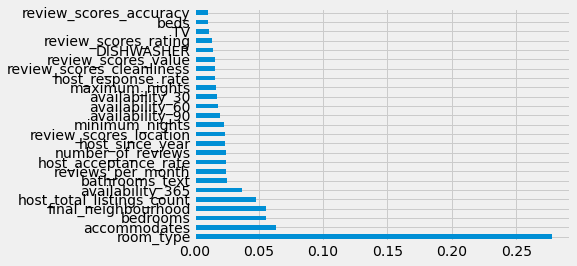

In [80]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(GBoost.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [81]:
figb = feat_importances.nlargest(25)

In [82]:
print(fi)
print(figb)

room_type                    0.355716
bedrooms                     0.078051
final_neighbourhood          0.059585
host_total_listings_count    0.043941
accommodates                 0.043333
availability_365             0.027751
bathrooms_text               0.026102
host_since_year              0.021542
host_acceptance_rate         0.021062
review_scores_location       0.019419
availability_60              0.019193
minimum_nights               0.019039
number_of_reviews            0.018951
availability_90              0.017919
reviews_per_month            0.017486
availability_30              0.016627
DISHWASHER                   0.016481
TV                           0.012896
host_response_rate           0.012301
maximum_nights               0.012126
review_scores_cleanliness    0.011494
review_scores_value          0.011213
review_scores_rating         0.010196
review_scores_checkin        0.008375
review_scores_accuracy       0.007967
dtype: float64
room_type                    0.2778

#### Adding 2 variables

We are first adding 2 variables and running a model to see how this impacts the score. If it has impact, we keep them. Also, we are going to remove other variables with low importance.

Negative/too little impact so will not be kept

In [83]:
#I know this has been done before, but these were dropped before creating X. Now I run them again here to include in X
airbnb['bedrooms_p_a'] = airbnb['bedrooms'] / airbnb['accommodates']
airbnb['bathrooms_p_a'] = airbnb['bathrooms_text'] / airbnb['accommodates']

In [84]:
airbnb.dropna(inplace=True)
X = airbnb.drop(columns = 'price')
y = airbnb['price']

In [85]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train)

(21256, 60)
(21256,)
(2657, 60)
(2657,)
(2657, 60)
(2657,)


array([[ 1.65835823,  0.43526154, -2.53526643, ...,  0.        ,
        -0.18720394, -0.16712656],
       [-1.75227802, -4.41970696, -2.53526643, ...,  0.        ,
        -0.18720394, -0.16712656],
       [-0.61539927,  0.43526154,  0.80376251, ...,  0.        ,
        -0.18720394, -0.16712656],
       ...,
       [-0.61539927,  0.43526154,  0.80376251, ...,  0.        ,
        -0.18720394, -1.06933325],
       [-0.61539927,  0.43526154,  0.80376251, ...,  0.        ,
        -0.18720394,  1.18618348],
       [-0.61539927, -1.16687807, -0.29811704, ...,  0.        ,
        -0.18720394, -0.16712656]])

In [86]:
#can check against 3 best performing models

In [87]:
regressor1.fit(X_train,y_train)
print(regressor1.score(X_test, y_test))
FE_regressor = regressor1.score(X_test, y_test)

difference_regressor = FE_regressor - grid_regressor #if positive, then keep the created variables
print(difference_regressor)

0.6328605059706132
-0.011008528470269785


In [88]:
predicted = regressor1.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FE_regressor_MAE = (metrics.mean_absolute_error(y_test, predicted))
FE_regressor_MSE = (metrics.mean_squared_error(y_test, predicted))
FE_regressor_RMSE=(np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 28.36614012521057
MSE: 1478.2835052662722
RMSE: 38.44845257310458


In [89]:
GBoost.fit(X_train, y_train)
print(GBoost.score(X_test, y_test))

FE_GBoost = GBoost.score(X_test, y_test)

difference_GBoost = FE_regressor - grid_GB #if positive, then keep the created variables
print(difference_GBoost)

0.7378179763946998
-0.10580086233208907


In [90]:
predicted = GBoost.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FE_GBoost_MAE = (metrics.mean_absolute_error(y_test, predicted))
FE_GBoost_MSE = (metrics.mean_squared_error(y_test, predicted))
FE_GBoost_RMSE=(np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 23.214761038239484
MSE: 1055.67329904863
RMSE: 32.49112646629276


In [91]:
GBoost2.fit(X_train, y_train)
print(GBoost2.score(X_test, y_test))

FE_GBoost2 = GBoost2.score(X_test, y_test)

0.7332449092872995


In [92]:
predicted = GBoost2.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FE_GBoost2_MAE = (metrics.mean_absolute_error(y_test, predicted))
FE_GBoost2_MSE = (metrics.mean_squared_error(y_test, predicted))
FE_GBoost2_RMSE=(np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 23.266158472327866
MSE: 1074.086708075131
RMSE: 32.77326209084367


#### Feature removal

Only keeping the 25 most important features to reduce noise in the model from features that have low predictive power

In [138]:
#After doing feature selection and only using most important 27 as there are 2 different features with GB compared o RFR:
X = airbnb[['bedrooms', 
                 'host_total_listings_count', 
                 'bathrooms_text',
                 'final_neighbourhood',
                 'room_type', 
                 'accommodates', 
                 'availability_365', 
                 'minimum_nights', 
                 'availability_90',
                 'host_since_year', 
                 'availability_30',
                 'reviews_per_month',
                 'availability_60',
                 'host_acceptance_rate',
                 'number_of_reviews',
                 'beds',
                 'maximum_nights',
                 'host_response_time',
                 'host_response_rate',
                 'review_scores_value',
                 'review_scores_location',
                 'review_scores_cleanliness',
                 'review_scores_rating', 'DISHWASHER', 'SMOKE ALARM']]
y = airbnb['price']

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train)

(21256, 25)
(21256,)
(2657, 25)
(2657,)
(2657, 25)
(2657,)


array([[-0.51654064, -0.18030769, -0.49056729, ...,  0.31974267,
         1.50653603,  0.34466756],
       [-0.51654064, -0.17828138, -0.49056729, ..., -0.00282515,
        -0.66377437,  0.34466756],
       [-0.51654064, -0.17220245, -0.49056729, ..., -0.37915427,
        -0.66377437,  0.34466756],
       ...,
       [ 0.80614651, -0.18030769,  1.38084303, ...,  0.44518571,
        -0.66377437,  0.34466756],
       [-0.51654064, -0.18030769, -0.49056729, ...,  0.48102657,
         1.50653603,  0.34466756],
       [-0.51654064, -0.14991304, -0.49056729, ..., -0.05658645,
        -0.66377437,  0.34466756]])

In [94]:
#linear regression with the new X and y

linear = LinearRegression()
linear.fit(X_train,y_train)
linear.score(X_test,y_test)

FR_score_linear = linear.score(X_test, y_test)

#decision tree with the new X and y
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test,y_test)

In [95]:
#running the RFR for the final data set with the best params for the one with amenities
regressor2.fit(X_train,y_train)
regressor2.score(X_test, y_test)

FR_score_regressor2 = regressor2.score(X_test, y_test)

In [96]:
predicted = regressor2.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FR_regressor2_MAE = (metrics.mean_absolute_error(y_test, predicted))
FR_regressor2_MSE = (metrics.mean_squared_error(y_test, predicted))
FR_regressor2_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 26.995738927290283
MSE: 1392.5828803452575
RMSE: 37.31732681135209


In [97]:
#running the RFR for the final data set with the best params for the one without amenities
regressor1.fit(X_train,y_train)
regressor1.score(X_test, y_test)

FR_score_regressor1 = regressor1.score(X_test, y_test)

In [98]:
predicted = regressor1.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FR_regressor1_MAE = (metrics.mean_absolute_error(y_test, predicted))
FR_regressor1_MSE = (metrics.mean_squared_error(y_test, predicted))
FR_regressor1_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 26.93207453500241
MSE: 1388.2967704736134
RMSE: 37.259854675959396


In [139]:
#GBOOST with best params before amenities
GBoost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.02,
                                   max_depth=8, subsample = 0.5)
GBoost.fit(X_train, y_train)
GBoost.score(X_test, y_test)

FR_score_GBoost = GBoost.score(X_test, y_test)

In [140]:
predicted = GBoost.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FR_GBoost_MAE = (metrics.mean_absolute_error(y_test, predicted))
FR_GBoost_MSE = (metrics.mean_squared_error(y_test, predicted))
FR_GBoost_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: tf.Tensor(23.715504613272522, shape=(), dtype=float64)
MSE: tf.Tensor(1090.3883303380292, shape=(), dtype=float64)
RMSE: 33.02102860811621


In [141]:
predicted = GBoost.predict(X_valid)
predicted

print('MAE:', metrics.mean_absolute_error(y_valid, predicted))
print('MSE:', metrics.mean_squared_error(y_valid, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predicted)))

FR_GBoost_MAE_valid = (metrics.mean_absolute_error(y_valid, predicted))
FR_GBoost_MSE_valid = (metrics.mean_squared_error(y_valid, predicted))
FR_GBoost_RMSE_valid = (np.sqrt(metrics.mean_squared_error(y_valid, predicted)))

MAE: tf.Tensor(24.41696891766295, shape=(), dtype=float64)
MSE: tf.Tensor(1217.6591265295413, shape=(), dtype=float64)
RMSE: 34.894972797375


In [101]:
#GBOOST with best params with amenities
GBoost2 = GradientBoostingRegressor(learning_rate=0.03, 
                                    max_depth=6, 
                                    n_estimators=1500,
                                    subsample=0.9)

GBoost2.fit(X_train, y_train)
GBoost2.score(X_test, y_test)

FR_score_GBoost2 = GBoost2.score(X_test, y_test)

In [102]:
predicted = GBoost2.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FR_GBoost2_MAE = (metrics.mean_absolute_error(y_test, predicted))
FR_GBoost2_MSE = (metrics.mean_squared_error(y_test, predicted))
FR_GBoost2_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 26.08862003713875
MSE: 1328.9237860737956
RMSE: 36.45440694996691


#### With the features

First, we thought that the feature engineering was not really helping as the score did not improve. However, now we see that the MAE is lower when the features are taken into account. Therefore, here we will rerun the last part including the two new features to check if this is indeed the case. the MAE reduced form 40 to 35, which is a lot with these numbers.

In [ ]:
#After doing feature selection and only using most important 27 as there are 2 different features with GB compared o RFR:
X = airbnb[['bedrooms', 
                 'host_total_listings_count', 
                 'bathrooms_text',
                 'final_neighbourhood',
                 'room_type', 
                 'accommodates', 
                 'availability_365', 
                 'minimum_nights', 
                 'availability_90',
                 'host_since_year', 
                 'availability_30',
                 'reviews_per_month',
                 'availability_60',
                 'host_acceptance_rate',
                 'number_of_reviews',
                 'beds',
                 'maximum_nights',
                 'host_response_time',
                 'host_response_rate',
                 'review_scores_value',
                 'review_scores_location',
                 'review_scores_cleanliness',
                 'review_scores_rating', 'DISHWASHER', 'SMOKE ALARM', 'bedrooms_p_a', 'bathrooms_p_a']]
y = airbnb['price']

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train)

As all previous results show that the GBoost performs best, we only perform these 2.

In [104]:
#GBOOST with best params with amenities
GBoost2 = GradientBoostingRegressor(learning_rate=0.03, 
                                    max_depth=6, 
                                    n_estimators=1500,
                                    subsample=0.9)

GBoost2.fit(X_train, y_train)
GBoost2.score(X_test, y_test)

FR_FE_GBoost2 = GBoost2.score(X_test, y_test)

In [105]:
predicted = GBoost2.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

FR_FE_GBoost2_MAE = (metrics.mean_absolute_error(y_test, predicted))
FR_FE_GBoost2_MSE = (metrics.mean_squared_error(y_test, predicted))
FR_FE_GBoost2_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 26.28006868463494
MSE: 1345.5421418021774
RMSE: 36.681632212896105


In [106]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

grid_accuracy = evaluate(GBoost2, X_test, y_test)

print(best_grid)
print(grid_accuracy)

In [107]:
#GBOOST with best params
GBoost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.02,
                                   max_depth=8, subsample = 0.5)
GBoost.fit(X_train, y_train)
GBoost.score(X_test, y_test)

FR_FE_GBoost = GBoost.score(X_test, y_test)

In [108]:
predicted = GBoost.predict(X_test)
predicted

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))


FR_FE_GBoost_MAE = (metrics.mean_absolute_error(y_test, predicted))
FR_FE_GBoost_MSE = (metrics.mean_squared_error(y_test, predicted))
FR_FE_GBoost_RMSE = (np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 26.605257529747075
MSE: 1364.1579967813366
RMSE: 36.93450956465155


In [ ]:
# Super inefficient in terms of computational resources
rfecv = RFECV(estimator=GBoost, cv=5)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

In [109]:
scores = {'Action' : ['Base', 
                      'MAE', 
                      'MSE', 
                      'RMSE',
                      'Grid Search', 
                      'MAE', 
                      'MSE', 
                      'RMSE', 
                      'Feature Engineering', 
                      'MAE', 
                      'MSE', 
                      'RMSE', 
                      'Feature Removal', 
                      'MAE', 
                      'MSE', 
                      'RMSE', 
                      'Feature engineering and removal', 
                      'MAE', 
                      'MSE', 
                      'RMSE'],
         'Linear regression' : [base_linear, 
                                None, 
                                None,
                                None,
                                None, 
                                None, 
                                None, 
                                None,
                                None, 
                                None, 
                                None, 
                                None,
                                FR_score_linear, 
                                None, 
                                None, 
                                None, 
                                None, 
                                None, 
                                None, 
                                None],
         'Decision Tree' : [base_DT, 
                            None, 
                            None, 
                            None, 
                            None,
                           None, 
                            None, 
                            None, 
                            None,
                           None, 
                            None, 
                            None, 
                            None,
                           None, 
                            None, 
                            None, 
                            None,
                           None, 
                            None, 
                            None],
         'regressor1' : [base_regressor, 
                         base_regressor_MAE, 
                         base_regressor_MSE, 
                         base_regressor_RMSE, 
                         grid_regressor, 
                         grid_regressor_MAE, 
                         grid_regressor_MSE, 
                         grid_regressor_RMSE,
                         FE_regressor,
                         FE_regressor_MAE,
                         FE_regressor_MSE,
                         FE_regressor_RMSE,
                         FR_score_regressor1,
                         FR_regressor1_MAE,
                          FR_regressor1_MSE,
                          FR_regressor1_RMSE,
                         None,
                        None,
                        None,
                        None],
         'regressor2' : [base_regressor, 
                         base_regressor_MAE, 
                         base_regressor_MSE, 
                         base_regressor_RMSE, 
                         grid2_regressor,
                         grid2_regressor_MAE, 
                         grid2_regressor_MSE, 
                         grid2_regressor_RMSE,
                         None,
                         None,
                         None,
                         None,
                         FR_score_regressor2,
                         FR_regressor2_MAE,
                          FR_regressor2_MSE,
                          FR_regressor2_RMSE,
                         None,
                        None,
                        None,
                        None],
         'GBoost' : [base_GB,
                     base_GB_MAE,
                     base_GB_MSE,
                     base_GB_RMSE,
                     grid_GB,
                     grid_GB_MAE,
                     grid_GB_MSE,
                     grid_GB_RMSE,
                     FE_GBoost,
                     FE_GBoost_MAE,
                     FE_GBoost_MSE,
                     FE_GBoost_RMSE,
                     FR_score_GBoost,
                     FR_GBoost2_MAE,
                      FR_GBoost2_MSE,
                      FR_GBoost2_RMSE,
                     FR_FE_GBoost,
                    FR_FE_GBoost_MAE,
                      FR_FE_GBoost_MSE,
                      FR_FE_GBoost_RMSE],
         'GBoost2' : [base_GB,
                     base_GB_MAE,
                     base_GB_MSE,
                     base_GB_RMSE,
                     grid2_GB,
                     grid2_GB_MAE,
                     grid2_GB_MSE,
                     grid2_GB_RMSE, 
                      FE_GBoost2,
                      FE_GBoost2_MAE,
                      FE_GBoost2_MSE,
                      FE_GBoost2_RMSE,
                      FR_score_GBoost2,
                      FR_GBoost2_MAE,
                      FR_GBoost2_MSE,
                      FR_GBoost2_RMSE,
                      FR_FE_GBoost2,
                      FR_FE_GBoost2_MAE,
                      FR_FE_GBoost2_MSE,
                      FR_FE_GBoost2_RMSE]}

results = pd.DataFrame(data = scores)
results

,Action,Linear regression,Decision Tree,regressor1,regressor2,GBoost,GBoost2
0,Base,-219836.393611,0.068498,0.704272,0.704272,0.659197,0.659197
1,MAE,NaN,NaN,24.618205,24.618205,26.701549,26.701549
2,MSE,NaN,NaN,1172.730109,1172.730109,1351.478472,1351.478472
3,RMSE,NaN,NaN,34.245147,34.245147,36.762460,36.762460
4,Grid Search,NaN,NaN,0.643869,0.644622,0.738661,0.732541
5,MAE,NaN,NaN,28.134071,28.089611,22.815927,23.049665
6,MSE,NaN,NaN,1412.264190,1409.276309,1036.358044,1060.629351
7,RMSE,NaN,NaN,37.580104,37.540329,32.192515,32.567305
8,Feature Engineering,NaN,NaN,0.632861,NaN,0.737818,0.733245
9,MAE,NaN,NaN,28.366140,NaN,23.214761,23.266158


#### Neural Network

In [106]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import tensorflow as tf

In [103]:
#!pip install tensorflow

     |████████████████████████████████| 217.5 MB 73 kB/s  eta 0:00:012/s eta 0:01:37
     |████████████████████████████████| 57 kB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 87.3 MB/s eta 0:00:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 1.4 MB 61.1 MB/s eta 0:00:01
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
     |████████████████████████████████| 1.6 MB 87.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 5.8 MB 68.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 53.3 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 63.7 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 72.4 MB/s eta 0:00:01
     |████████████████████████████████| 

In [133]:
def best_model_5(x_size, y_size):
    model = Sequential()
    model.add(Dense(80, activation="tanh", input_shape=(x_size,)))
    model.add(Dropout(0.2))
    model.add(Dense(120, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation="relu"))
    model.add(Dropout(0.0))
    model.add(Dense(y_size))
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=[metrics.mae])
    return model

In [134]:
model = best_model_5(X_train.shape[1], y_train.shape[0])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 80)                4640      
                                                                 
 dropout_14 (Dropout)        (None, 80)                0         
                                                                 
 dense_23 (Dense)            (None, 120)               9720      
                                                                 
 dropout_15 (Dropout)        (None, 120)               0         
                                                                 
 dense_24 (Dense)            (None, 20)                2420      
                                                                 
 dropout_16 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)               

In [135]:
epochs = 200
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  200
Batch size:  128


In [136]:
keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]

In [137]:
history = model.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, 
    validation_data=(X_valid, y_valid),
    callbacks=keras_callbacks)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose=0)
valid_score = model.evaluate(X_valid, y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()